In [1]:
# Imports
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Dataset

import os
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from captum.attr import LayerGradCam, FeatureAblation, LayerActivation, IntegratedGradients, GradientShap

from functools import partial

import sys
# Add the upper directory to the path
sys.path.append("../Models/")
from CustomCNNVessel import CustomResNet

from VesselsDatasetLoader import get_dataset

In [2]:
# Default device plus free memory
torch.cuda.empty_cache()
device = torch.device("cuda")

# Dataset
dataset_type = 'vessel'
train_loader, test_loader = get_dataset(batch_size=1)

# Model and weight
model = CustomResNet(num_classes=2).to(device)
model.load_state_dict(torch.load(f"../Models/custom_cnn_{dataset_type}.pth"))
model.eval()  # Set the model to evaluation mode

CustomResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (resblock1): ResidualBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (skip): Sequential(
      (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (resblock2): ResidualBlock(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, trac

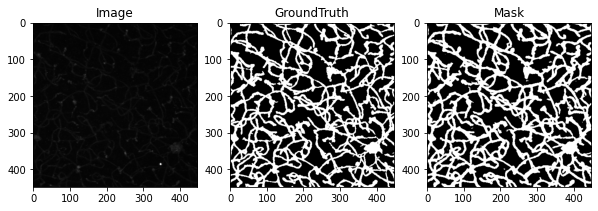

In [6]:
input_image, input_mask = next(iter(test_loader))
input_image = input_image.to(device)
out = model(input_image)
out_max = torch.argmax(out, dim=1, keepdim=True)

fig, axes = plt.subplots(1, 3, figsize=(10, 5))  # 1 row, 2 columns

axes[0].imshow(input_image.squeeze(0).cpu().permute(1,2,0).numpy(), cmap='gray')
axes[0].set_title('Image')
axes[1].imshow(input_mask.cpu().squeeze(0).permute(1,2,0).numpy(), cmap='gray')
axes[1].set_title('GroundTruth')
axes[2].imshow(out_max.cpu().squeeze(0).permute(1,2,0).numpy(), cmap='gray')
axes[2].set_title('Mask')
plt.show()

In [11]:
activations = model.forward_activation(input_image)
def print_decoder_activations_shapes(activations):
    # List of keys that belong to the decoder and the final layer
    decoder_keys = ['upconv1', 'skip1', 'upconv2', 'skip2', 'upconv3', 'skip3', 'upconv4', 'skip4', 'x_final']

    for key in decoder_keys:
        print(f"Shape of {key}: {activations[key].shape}")

In [12]:
print_decoder_activations_shapes(activations)

Shape of upconv1: torch.Size([1, 512, 56, 56])
Shape of skip1: torch.Size([1, 512, 56, 56])
Shape of upconv2: torch.Size([1, 256, 112, 112])
Shape of skip2: torch.Size([1, 256, 112, 112])
Shape of upconv3: torch.Size([1, 128, 224, 224])
Shape of skip3: torch.Size([1, 128, 224, 224])
Shape of upconv4: torch.Size([1, 64, 448, 448])
Shape of skip4: torch.Size([1, 64, 448, 448])
Shape of x_final: torch.Size([1, 2, 448, 448])
